In [11]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def exp_num_seq(nums = []):
    return [math.exp(i) for i in nums]


In [17]:
x = [1,2,3]

<IPython.core.display.Javascript object>


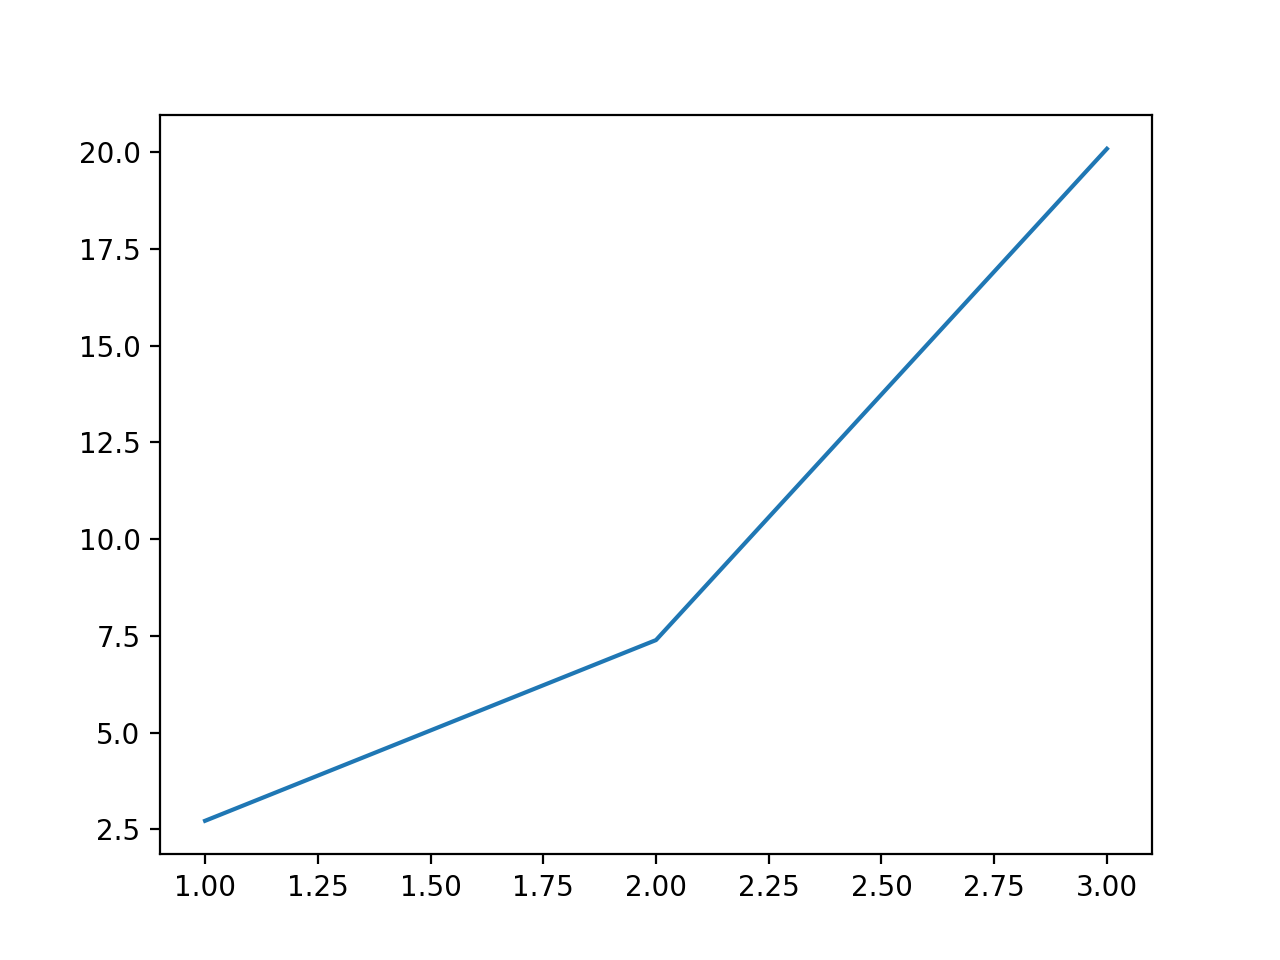

In [10]:
plt.plot(x, exp_num_seq(x))

In [21]:
def over_sum(nums = []):
    total = np.sum(nums)
    return [float(i)/total for i in nums]
over_sum(x)

[0.16666666666666666, 0.33333333333333331, 0.5]

<IPython.core.display.Javascript object>


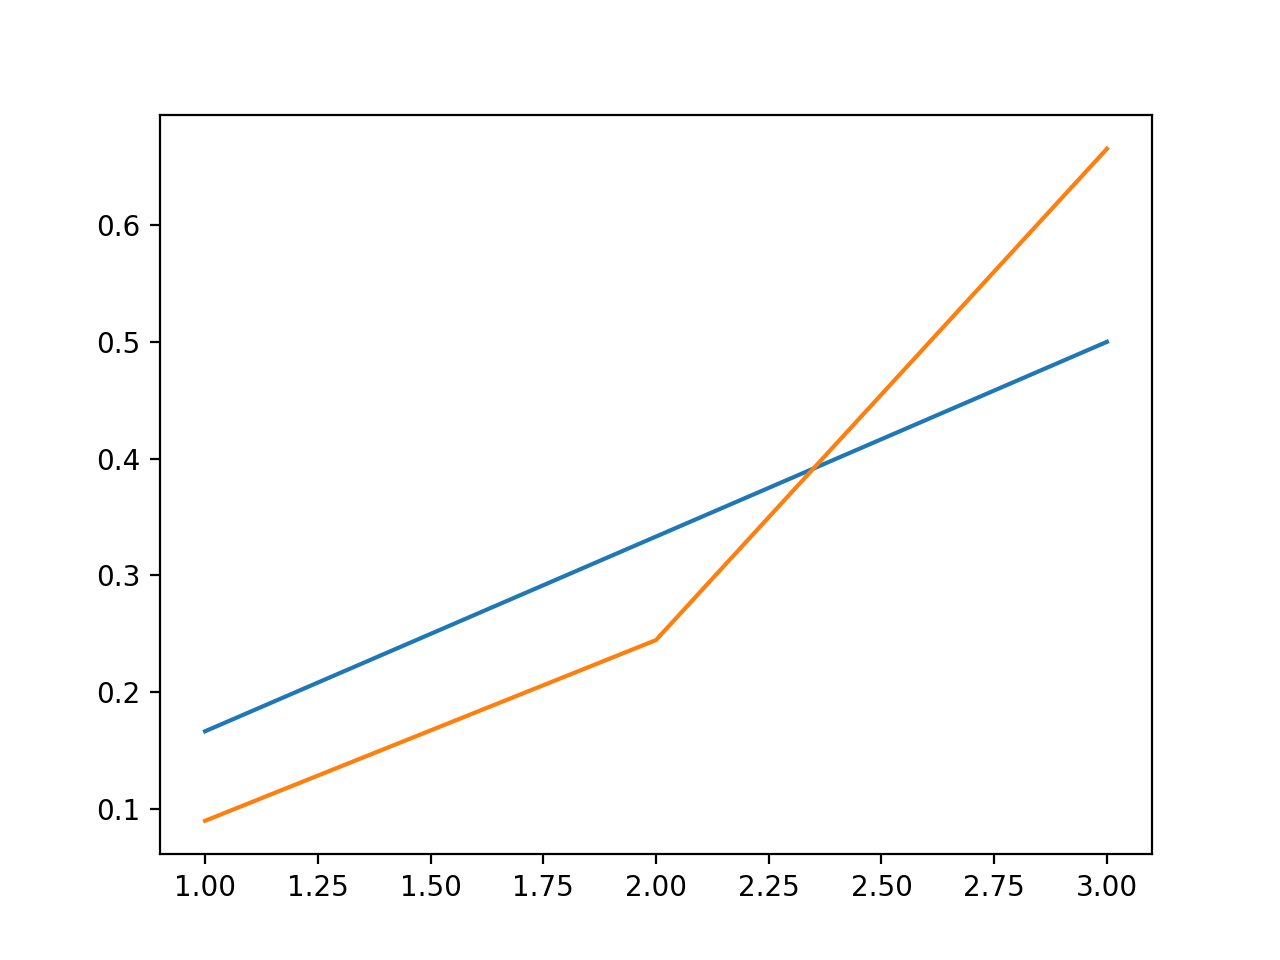

In [22]:
plt.plot(x, over_sum(x))

In [23]:
def soft_max(nums = []):
    exp_nums = exp_num_seq(nums)
    total = np.sum(exp_nums)
    return [float(i)/total for i in exp_nums]

<IPython.core.display.Javascript object>


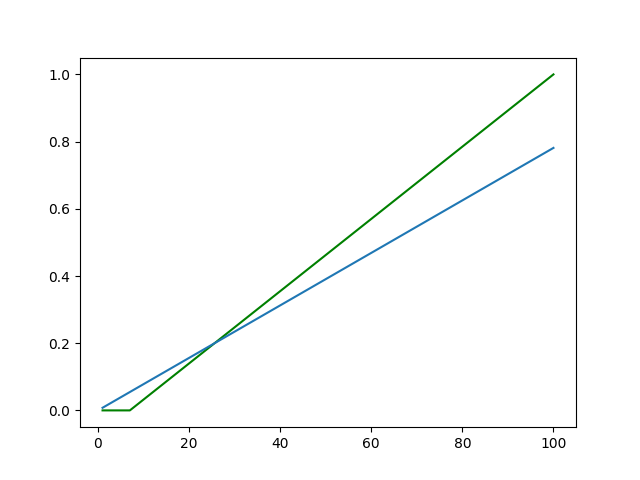

In [36]:
x = [1,2,3,4,5,6,7,100]
plt.plot(x, soft_max(x), label="soft max", color="green")
plt.plot(x, over_sum(x), label="standard")

# Real Shit happens here


In [27]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [28]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


In [29]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [37]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickl

In [38]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [46]:
# Only ndarray support assign 
a = np.ndarray(3)
a[:] = 1
a

array([ 1.,  1.,  1.])

In [51]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  #This assignment is using array selection 
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [50]:
np.random.permutation(20000)

array([ 2427, 11211,  4616, ..., 15175, 10922,  2810])

In [52]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)
    

Compressed pickle size: 690800512


In [83]:
import hashlib
# using %time to time a function
# hash(str(takes a long long time))
# hash(nparray.tostring()) is much much faster 1000x
# hashlib.sha256 is slower but more secure, and it return object, using hexdigest to compare
def display_unique_percentage(target_set):
    """
    output (unique_images_num, data_set_images_num)
    """
    dedup_set = set()
    for img_pixels in target_set:
        dedup_set.add(hashlib.sha256(img_pixels).hexdigest())
    return len(dedup_set), len(target_set)
    pass

%time display_unique_percentage(train_dataset[:])

CPU times: user 2.24 s, sys: 36.2 ms, total: 2.28 s
Wall time: 2.32 s


(187217, 200000)

In [64]:
np.array([1,2,3])

array([1, 2, 3])

In [82]:
hashlib.sha256(np.array([1,2])).hexdigest() == hashlib.sha256(np.array([1,2])).hexdigest()


True

In [87]:
def extract_overlap(set_1, set_2):
    """
    return overlap images{}
    
    """
    dedup_set = set()
    overlap = {}
    for img_pixels in set_1:
        dedup_set.add(hashlib.sha256(img_pixels).hexdigest())
    for i, img_pixels in enumerate(set_2):
        if hashlib.sha256(img_pixels).hexdigest() in dedup_set:
            overlap[i] = img_pixels
    return len(overlap)        
    pass

%time print(extract_overlap(train_dataset, test_dataset))
%time print(extract_overlap(train_dataset, valid_dataset))
%time print(extract_overlap(test_dataset, valid_dataset))


1324
CPU times: user 2.4 s, sys: 35.7 ms, total: 2.44 s
Wall time: 2.48 s
1067
CPU times: user 2.33 s, sys: 30.4 ms, total: 2.36 s
Wall time: 2.38 s
153
CPU times: user 200 ms, sys: 957 µs, total: 201 ms
Wall time: 201 ms


# This space will saved for saniting dateset

In [149]:
def dedup_set(set_compare, set_to_remove, label_set_to_remove):
    """
    return 2 new np.array for train and label
    """
    dedup_set = set()
    index_to_remove = []
    for img_pixels in set_compare:
        dedup_set.add(hashlib.sha256(img_pixels).hexdigest())
    for i, img_pixels in enumerate(set_to_remove):
        if hashlib.sha256(img_pixels).hexdigest() in dedup_set:
            index_to_remove.append(i)
    return np.delete(set_to_remove, index_to_remove, 0), np.delete(label_set_to_remove, index_to_remove, 0)
def unique_set(target_set, target_label):
    """same as above, but for set's uniqueness"""
    dedup_set = set()
    index_to_remove = []
    for i, img_pixels in enumerate(target_set):
        hash_code = hashlib.sha256(img_pixels).hexdigest()
        if hash_code in dedup_set:
            index_to_remove.append(i)
        else:
            dedup_set.add(hash_code)
    return np.delete(target_set, index_to_remove, 0), np.delete(target_label, index_to_remove, 0)        

In [150]:
dedup_train_set, dedup_train_label = unique_set(train_dataset, train_labels)

In [160]:
dedup_train_set.shape, dedup_train_label.shape

((187217, 28, 28), (187217,))

# regression model

In [135]:
def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item])

In [88]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [91]:
sample_size = 20000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 2min 21s, sys: 1.69 s, total: 2min 22s
Wall time: 2min 26s


0.87660000000000005

In [161]:
def get_score(train_set, label_set):
    train_resize_set = train_set.reshape(train_set.shape[0], 28*28)
    %time regr.fit(train_resize_set, label_set)
    return regr.score(X_test, y_test)

In [162]:
get_score(dedup_train_set, dedup_train_label)

CPU times: user 26min 23s, sys: 18.4 s, total: 26min 41s
Wall time: 27min 11s


In [163]:
regr.score(X_test, y_test)

0.89400000000000002

In [165]:
test_x_dedup, test_y_dedup = unique_set(test_dataset, test_labels)
test_x_dedup, test_y_dedup = dedup_set(dedup_train_set, test_x_dedup, test_y_dedup)
test_x_dedup = test_x_dedup.reshape(test_x_dedup.shape[0], 28 * 28)

In [166]:
regr.score(test_x_dedup, test_y_dedup)

0.88466442564043124

# display section

<IPython.core.display.Javascript object>


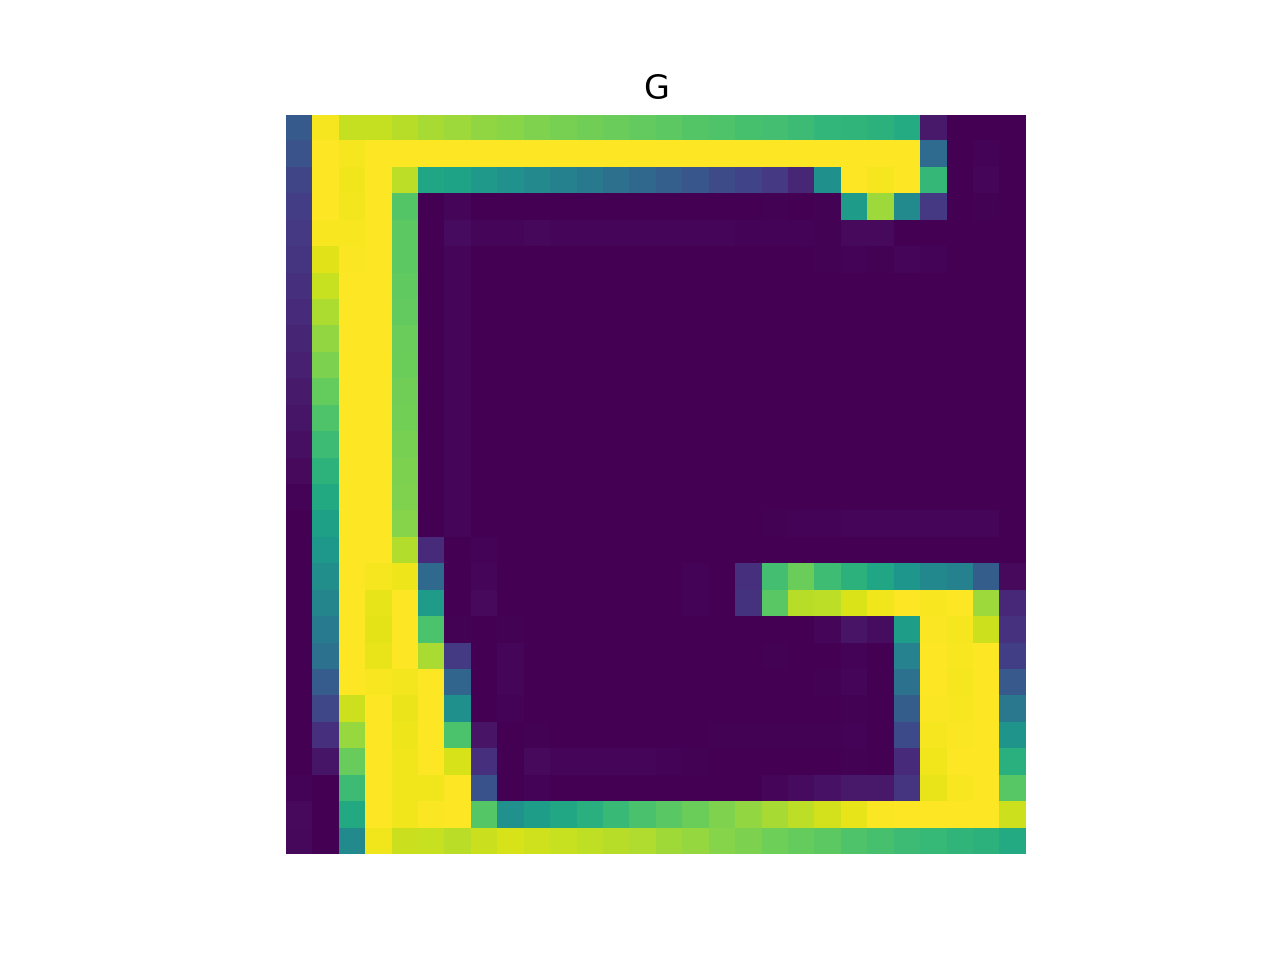

In [97]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
def disp_sample_dataset(image_pixels, label):
  plt.axis('off')
  plt.title(pretty_labels[label])
  plt.imshow(image_pixels)

disp_sample_dataset(valid_dataset[1], valid_labels[1])

In [101]:
def predict(data_set):
    reshaped_data_set = data_set.reshape(data_set.shape[0], 28 * 28)
    return regr.predict(reshaped_data_set)
predict(valid_dataset[0:1])

array([2], dtype=int32)

<IPython.core.display.Javascript object>


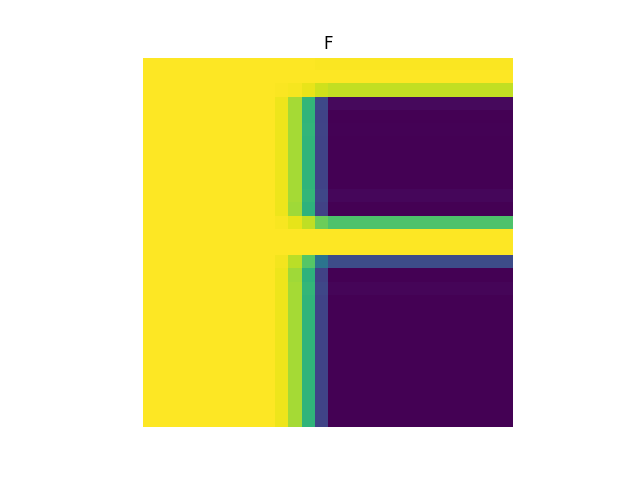

In [125]:
def display_predict(data_set, i = 0):
    disp_sample_dataset(data_set[i], predict(data_set[i:i+1])[0])
    pass 
display_predict(valid_dataset, 100)

# test with real img

<IPython.core.display.Javascript object>


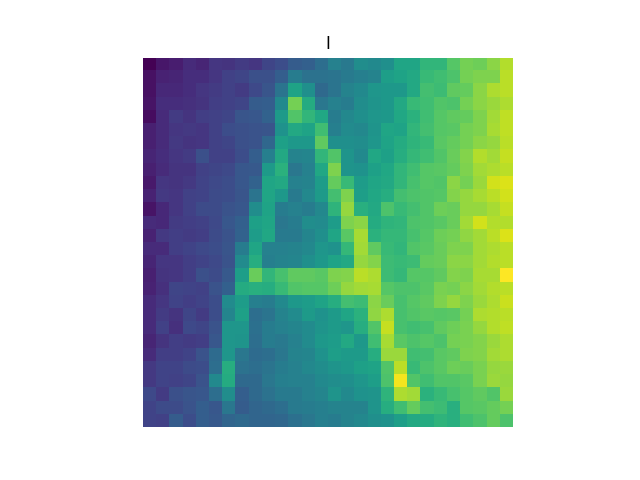

In [134]:
from PIL import Image
from PIL import ImageOps
def prepare_image_for_predict(image_name):
    image_name = os.path.join(os.path.join(data_root, 'my_images'),
                              image_name)
    img = Image.open(image_name).convert('L')
    new_img = img.resize((28,28))
    new_img = ImageOps.invert(new_img)
    new_img.save('temp.png')
    image_data = (ndimage.imread('temp.png').astype(float) - 
                    pixel_depth / 2) / pixel_depth
    display_predict(np.array([image_data]), 0)
    
prepare_image_for_predict("IMG_8209.JPG")